In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import h5py

In [0]:
with h5py.File('Dataset128.h5','r') as f:
  features=np.array(f['x_train'])
  targets=np.array(f['y_train'])
  # t=np.array(f['t'])

print(f'Shape of X: {features.shape}\nShape of Y: {targets.shape}')

features=pd.DataFrame(features)
features=(features-features.mean())/features.std()
features=np.array(features,dtype='float32')
targets=np.array(targets,dtype='float32')

print(f'Shape of features: {features.shape}\nShape of targets: {targets.shape}')

Shape of X: (12800, 1568)
Shape of Y: (12800, 1)
Shape of features: (12800, 1568)
Shape of targets: (12800, 1)


In [0]:
x_train=features[:10000,:]
y_train=targets[:10000,:]
x_test=features[10000:,:]
y_test=targets[10000:,:]
x_train=torch.from_numpy(x_train)
x_test=torch.from_numpy(x_test)
y_train=torch.from_numpy(y_train)
y_test=torch.from_numpy(y_test)
print(f'Shape of x_train: {x_train.shape}\nShape of y_train: {y_train.shape}\nShape of x_test: {x_test.shape}\nShape of y_test: {y_test.shape}')

Shape of x_train: torch.Size([10000, 1568])
Shape of y_train: torch.Size([10000, 1])
Shape of x_test: torch.Size([2800, 1568])
Shape of y_test: torch.Size([2800, 1])


In [0]:
class LSTM(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,num_layers):
    super(LSTM,self).__init__()
    self.input_size=input_size
    self.hidden_size=hidden_size
    self.output_size=output_size
    self.num_layers=num_layers

    self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
    self.fc1=nn.Linear(hidden_size,hidden_size)
    self.fc2=nn.Linear(hidden_size,output_size)
    self.dropout=nn.Dropout(p=0.7)

  def forward(self,x,hidden):
    x=x.view(1,-1,1568)

    lstm_out,hidden=self.lstm(x,hidden)
    fc_in=lstm_out.view(-1,self.hidden_size)
    fc_in=fc_in[-1,:]
    output=self.dropout(F.relu(self.fc1(self.dropout(F.relu(self.fc1(self.dropout(F.relu(self.fc1(fc_in)))))))))
    output=self.fc2(output)

    return output,hidden

  def hidden_init(self):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.num_layers, 1, self.hidden_size).normal_(),
              weight.new(self.num_layers, 1, self.hidden_size).normal_())
    return hidden



In [0]:
input_size=features.shape[1]
hidden_size=128
output_size=1
num_layers=3
lr=0.001
epochs=5
clip=5
seq_len=10
model=LSTM(input_size,hidden_size,output_size,num_layers)
criterion=nn.MSELoss()
optimizer=optim.RMSprop(model.parameters(),lr=lr,momentum=0.9)

train_losses, test_losses=list(), list()
y_train_pred,y_test_pred=list(), list()

for epoch in range(epochs):
  hidden=model.hidden_init()
  train_loss=0
  test_loss=0
  for i in range(len(y_train)-seq_len):
    # if i%1000==0:
    #   print(i/1000)
    x=x_train[i:i+seq_len,:]
    y=y_train[i+seq_len,:]
    optimizer.zero_grad()
    hidden= tuple([each.data for each in hidden])
    yhat,hidden=model(x,hidden)
    # if i in [1, 100, 1000, 4000]:
    #   print(yhat)
    #   print(y)
    loss=criterion(yhat,y)
    train_loss+=loss.item()
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    if epoch+1==epochs:
      y_train_pred.append(yhat.item())
  else:
    train_losses.append(train_loss)
    with torch.no_grad():
      model.eval()
      hidden=model.hidden_init()
      for i in range(len(y_test)-seq_len):
        x=x_test[i:i+seq_len,:]
        y=y_test[i+seq_len,:]
        hidden= tuple([each.data for each in hidden])
        yhat,hidden=model(x,hidden)
        loss=criterion(yhat,y)
        # if i in [1, 100, 1000, 2000]:
        #   print(yhat)
        #   print(y)
        test_loss+=loss.item()
        if epoch+1==epochs:
          y_test_pred.append(yhat.item())
      model.train()
    
    test_losses.append(test_loss)
    print('Epoch: {}/{}...'.format(epoch+1,epochs),
          'Training Loss: {:.4f}'.format(train_loss),
          'Test Loss: {:.4f}'.format(test_loss))




Epoch: 1/5... Training Loss: 16747.8839 Test Loss: 2.5277
Epoch: 2/5... Training Loss: 0.0199 Test Loss: 2.5301
Epoch: 3/5... Training Loss: 0.0198 Test Loss: 2.5631
Epoch: 4/5... Training Loss: 0.0200 Test Loss: 2.5285
Epoch: 5/5... Training Loss: 0.0198 Test Loss: 2.5405


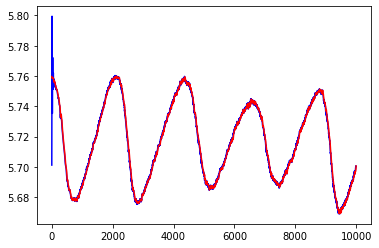

In [0]:
plt.plot(y_train_pred,c='b')
plt.plot(y_train,c='r')

[5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,
 5.701045989990234,


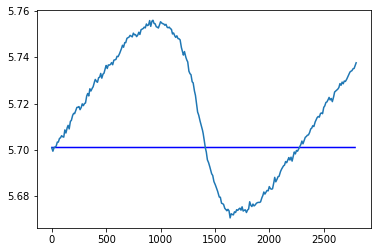

In [0]:
plt.plot(y_test_pred,c='b')
plt.plot(y_test)
y_test_pred